In [117]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
%matplotlib inline

In [118]:
def make_mini_batch(train_data, size_of_mini_batch, length_of_sequences):
    inputs  = np.empty(0)
    outputs = np.empty(0)
    for _ in range(size_of_mini_batch):
        index   = random.randint(0, len(train_data) - length_of_sequences)
        part    = train_data[index:index + length_of_sequences]
        inputs  = np.append(inputs, part[:, 0])
        outputs = np.append(outputs, part[-1, 1])
    inputs  = inputs.reshape(-1, length_of_sequences, 1)
    outputs = outputs.reshape(-1, 1)
    return (inputs, outputs)

In [119]:
def make_prediction_initial(train_data, index, length_of_sequences):
    return train_data[index:index + length_of_sequences, 0]

In [120]:
train_data_path             = "./sin.npy"
num_of_input_nodes          = 1
num_of_hidden_nodes         = 10
num_of_output_nodes         = 1
length_of_sequences         = 30
num_of_training_epochs      = 400
length_of_initial_sequences = 30
num_of_prediction_epochs    = 100
size_of_mini_batch          = 100
learning_rate               = 0.1
forget_bias                 = 1.0

In [121]:
train_data = np.load(train_data_path)
print("train_data:", train_data[:10])

('train_data:', array([[ 0.        ,  0.25066647],
       [ 0.25066647,  0.49737977],
       [ 0.49737977,  0.73624911],
       [ 0.73624911,  0.96350735],
       [ 0.96350735,  1.1755705 ],
       [ 1.1755705 ,  1.36909421],
       [ 1.36909421,  1.54102649],
       [ 1.54102649,  1.68865585],
       [ 1.68865585,  1.8096541 ],
       [ 1.8096541 ,  1.90211303]]))


In [122]:
# random seed fix
random.seed(0)
np.random.seed(0)
tf.set_random_seed(0)

In [115]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

with tf.Graph().as_default():
    input_ph      = tf.placeholder(tf.float32, [None, length_of_sequences, num_of_input_nodes], name="input")
    supervisor_ph = tf.placeholder(tf.float32, [None, num_of_output_nodes], name="supervisor")
    istate_ph     = tf.placeholder(tf.float32, [None, num_of_hidden_nodes * 2], name="istate")

    with tf.name_scope("inference") as scope:
        weight1_var = tf.Variable(tf.truncated_normal([num_of_input_nodes, num_of_hidden_nodes], stddev=0.1), name="weight1")
        weight2_var = tf.Variable(tf.truncated_normal([num_of_hidden_nodes, num_of_output_nodes], stddev=0.1), name="weight2")
        bias1_var   = tf.Variable(tf.truncated_normal([num_of_hidden_nodes], stddev=0.1), name="bias1")
        bias2_var   = tf.Variable(tf.truncated_normal([num_of_output_nodes], stddev=0.1), name="bias2")
        
        weight1_hist = tf.histogram_summary("layer1/weights", weight1_var)
        weight2_hist = tf.histogram_summary("layer2/weights", weight2_var)
        bias1_hist = tf.histogram_summary("layer1/biases", bias1_var)
        bias2_hist = tf.histogram_summary("layer2/biases", bias2_var)
        
        in1 = tf.transpose(input_ph, [1, 0, 2])         # (batch, sequence, data) -> (sequence, batch, data)
        in2 = tf.reshape(in1, [-1, num_of_input_nodes]) # (sequence, batch, data) -> (sequence * batch, data)
        in3 = tf.matmul(in2, weight1_var) + bias1_var
        in4 = tf.split(0, length_of_sequences, in3)     # sequence * (batch, data)

        cell = tf.nn.rnn_cell.BasicLSTMCell(num_of_hidden_nodes, forget_bias=forget_bias)
        rnn_output, states_op = tf.nn.rnn(cell, in4, initial_state=istate_ph)
        output_op = tf.matmul(rnn_output[-1], weight2_var) + bias2_var

    with tf.name_scope("loss") as scope:
        square_error = tf.reduce_mean(tf.square(output_op - supervisor_ph))
        loss_op      = square_error
        tf.scalar_summary("loss", loss_op)

    with tf.name_scope("training") as scope:
        training_op = optimizer.minimize(loss_op)

    summary_op = tf.merge_all_summaries()
    init = tf.initialize_all_variables()

    with tf.Session() as sess:
        saver = tf.train.Saver()
        summary_writer = tf.train.SummaryWriter("data", graph=sess.graph)
        sess.run(init)

        for epoch in range(num_of_training_epochs):
            inputs, supervisors = make_mini_batch(train_data, size_of_mini_batch, length_of_sequences)

            train_dict = {
                input_ph:      inputs,
                supervisor_ph: supervisors,
                istate_ph:     np.zeros((size_of_mini_batch, num_of_hidden_nodes * 2)),
            }
            sess.run(training_op, feed_dict=train_dict)

            if (epoch + 1) % 10 == 0:
                summary_str, train_loss = sess.run([summary_op, loss_op], feed_dict=train_dict)
                summary_writer.add_summary(summary_str, epoch)
                print("train#%d, train loss: %e" % (epoch + 1, train_loss))
#            if (epoch + 1) % 50 == 0:
#                rnn_output_v = sess.run(rnn_output, feed_dict=train_dict)
#                print(" rnn_output {}".format(rnn_output_v[-1]))

        inputs  = make_prediction_initial(train_data, 0, length_of_initial_sequences)
        outputs = np.empty(0)
        states  = np.zeros((num_of_hidden_nodes * 2)),

        print("initial:", inputs)
        np.save("initial.npy", inputs)

        for epoch in range(num_of_prediction_epochs):
            pred_dict = {
                input_ph:  inputs.reshape((1, length_of_sequences, 1)),
                istate_ph: states,
            }
            output, states = sess.run([output_op, states_op], feed_dict=pred_dict)
            print("prediction#%d, output: %f" % (epoch + 1, output))

            inputs  = np.delete(inputs, 0)
            inputs  = np.append(inputs, output)
            outputs = np.append(outputs, output)

        print("outputs:", outputs)
        np.save("output.npy", outputs)

        saver.save(sess, "data/model")

train#10, train loss: 5.625951e-01
train#20, train loss: 5.661723e-02
train#30, train loss: 2.144414e-02
train#40, train loss: 1.665445e-02
train#50, train loss: 6.800339e-03
train#60, train loss: 4.401741e-03
train#70, train loss: 2.450693e-03
train#80, train loss: 1.456132e-03
train#90, train loss: 1.000163e-03
train#100, train loss: 1.243553e-03
train#110, train loss: 1.158298e-03
train#120, train loss: 8.685333e-04
train#130, train loss: 8.903560e-04
train#140, train loss: 1.471702e-03
train#150, train loss: 6.185614e-04
train#160, train loss: 5.985487e-04
train#170, train loss: 5.586204e-04
train#180, train loss: 6.011687e-04
train#190, train loss: 6.070394e-04
train#200, train loss: 5.848721e-04
train#210, train loss: 4.656026e-04
train#220, train loss: 4.620160e-04
train#230, train loss: 5.283157e-04
train#240, train loss: 7.741472e-04
train#250, train loss: 5.399532e-04
train#260, train loss: 3.860152e-04
train#270, train loss: 4.000524e-04
train#280, train loss: 2.953278e-04
t

len of pred: 100


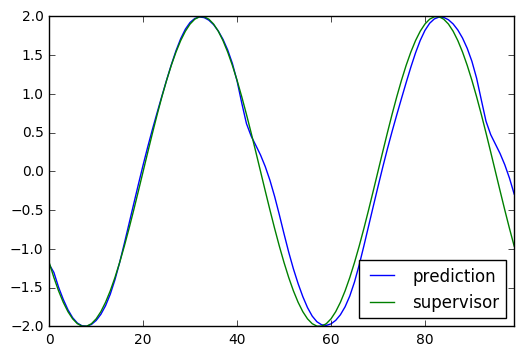

In [116]:
pred = np.load('output.npy')
print("len of pred: {}".format(len(pred)))
df = pd.DataFrame({'supervisor': train_data[length_of_initial_sequences:length_of_initial_sequences+len(pred),0], 'prediction': pred})
df.plot()

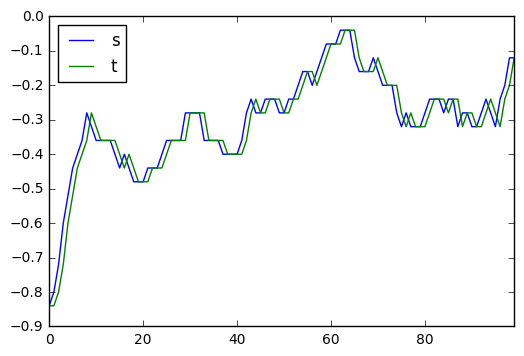

In [74]:
df = pd.DataFrame({'t': train_data[0:len(pred),0], 's': train_data[0:len(pred),1]})
df.head(600).plot()